In [267]:
import geopandas as gpd
import os
import xarray as xr
import numpy as np
import pandas as pd

In [268]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform/old_data/data'

In [269]:
pv_geoms = gpd.read_file(f"{data_dir}/shapefiles/photovoltaic.shp")

In [270]:
# Filter the data to have farms bigger then 5 km2
threshold_area = 5000 #m^2 ~50mx100m
pv_geoms_32632 = pv_geoms.to_crs(32632)
big_pv_geoms_32632 = pv_geoms_32632.where(pv_geoms_32632["geometry"].area > threshold_area).dropna()
big_pv_geoms = big_pv_geoms_32632.to_crs(4326)
print(f"Number of selected PV Farms: {len(big_pv_geoms)}")

Number of selected PV Farms: 43


In [ ]:
52

In [335]:
# Extract S2 data for the farms 
for i, geom in big_pv_geoms_32632.iterrows():
    data = xr.open_dataset(f"{data_dir}/netcdfs/S2_2022_{i}.nc",decode_coords="all")
    
    ## This step to fill the gaps (nan values) spatially
    data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
    #data_filled['crs'] = data.crs
    data.rio.write_crs("epsg:32633", inplace=True) #32633
    
    ## Filter clouds pixels
    cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
    geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
    data = data.where(~cloud_mask)
    
    ## Clip the farm polygon
    clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
      
    
    break

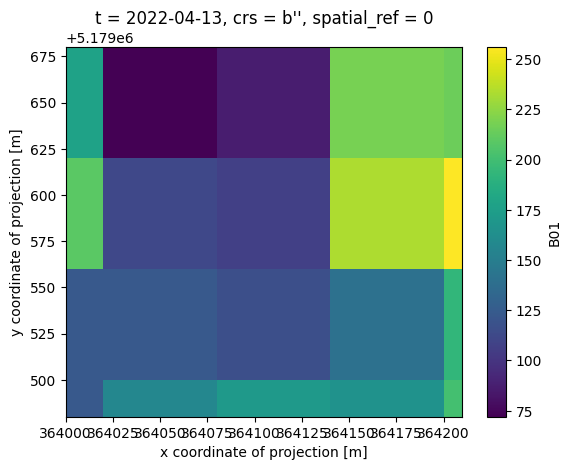

In [336]:
data['B01'][30].plot()

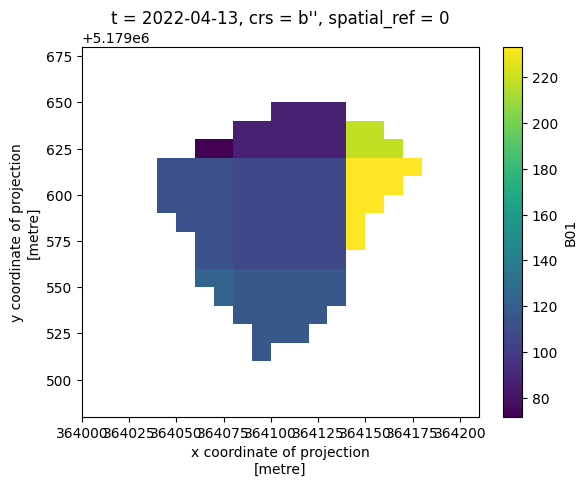

In [337]:
clipped['B01'][30].plot()

In [338]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[5:].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/netcdfs/S2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 800 is not exist.


In [339]:
pv_samples = np.vstack(all_pixels_ts)
pv_samples.shape

(8060, 11, 365)

In [340]:
y1 = np.ones(pv_samples.shape[0])

In [341]:
# Extract S2 data for the photvoltaic farms - pixels outside the polygons "labels as 0"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[5:].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/netcdfs/S2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=True)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 800 is not exist.


In [342]:
non_pv_samples = np.vstack(all_pixels_ts)
non_pv_samples.shape

(22551, 11, 365)

In [343]:
y0 = np.zeros(non_pv_samples.shape[0])

#### Combine both PV and Non-PV togehter 

In [346]:
tr_data = np.vstack([pv_samples, non_pv_samples[:12000]])
y = np.hstack([y1, y0[:12000]])

In [347]:
print(tr_data.shape)
print(y.shape)

(20060, 11, 365)
(20060,)


### Modeling

In [348]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from tsai.all import *

In [349]:
tr_data = np.nan_to_num(tr_data, nan=-999999)

In [350]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    X, y, splits = combine_split_data([x_train, x_val], [y_train, y_val])
    
    tfms  = [None, [Categorize()]] #[TSStandardize()] #[None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[8, 16], batch_tfms=[TSStandardize()], num_workers=0)

    
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=accuracy)
    
    learn.fit_one_cycle(5, lr_max=1e-3)

    # Validation
    valid_dl = dls.valid
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
    (valid_targets == valid_preds).float().mean()
    score = accuracy_score(valid_preds, valid_targets)
    print(f'Accuracy Score: {score}')
    i+=1
    break

########### Fold number 1 


epoch,train_loss,valid_loss,accuracy,time
0,0.575381,1.231831,0.598205,00:41
1,0.569505,1.189122,0.603190,00:40
2,0.484654,5.159141,0.598205,00:41
3,0.409024,1.155294,0.613659,00:39
4,0.395000,0.789443,0.583749,00:38


Accuracy Score: 0.5837487537387837


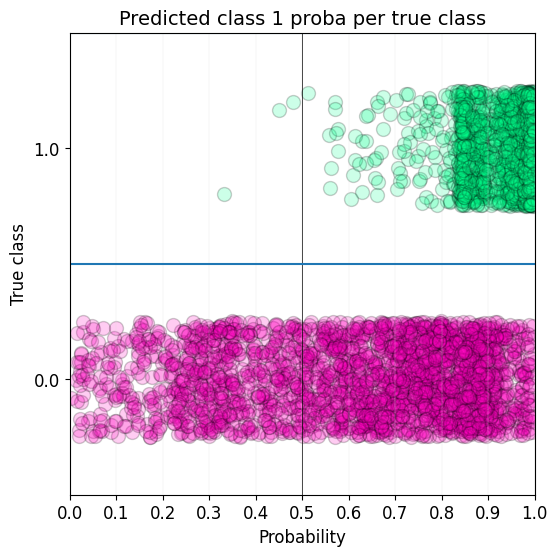

In [351]:
learn.show_probas()

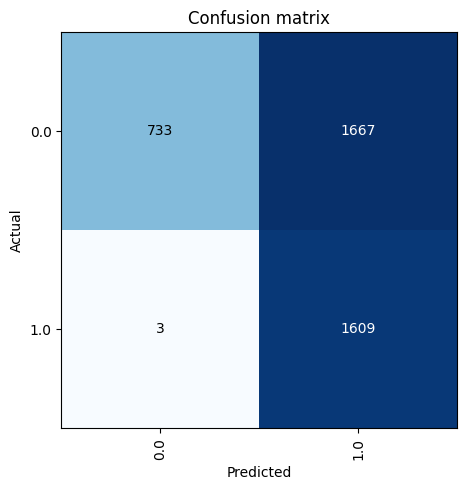

In [352]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Test 

In [353]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[:5].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/netcdfs/S2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        
        df = ds_daily_interp.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    except:
        print(f"This polygon id: {i} is not exist.")
        
        
    break

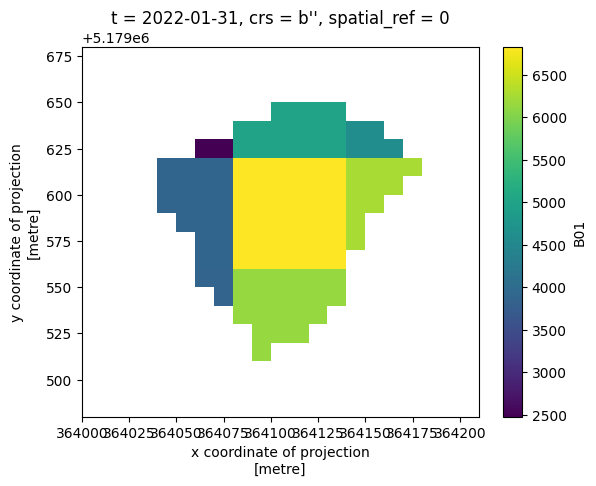

In [354]:
clipped['B01'][30].plot()

In [355]:
te_samples = np.vstack(all_pixels_ts)
te_samples = np.nan_to_num(te_samples, nan=-999999)

In [356]:
te_samples.shape

(420, 11, 365)

In [357]:
test_ds = dls.dataset.add_test(te_samples)

In [358]:
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)

In [360]:
pred = np.array(np.argmax(test_probas, axis=1))
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,

In [361]:
binary_mask =   pred.reshape((21, 20))

In [362]:
binary_mask.shape

(21, 20)

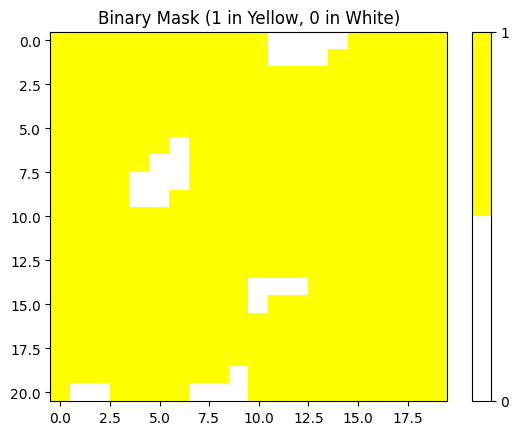

In [363]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a custom colormap with yellow for 1 and white for 0
custom_cmap = ListedColormap(['white', 'yellow'])

# Plot the binary mask
plt.imshow(binary_mask, cmap=custom_cmap, aspect='auto')

# Add colorbar for reference
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0', '1'])

plt.title('Binary Mask (1 in Yellow, 0 in White)')
plt.show()